In [5]:
import os
import random
import numpy as np
import nibabel as nib
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms.functional as TF
from torchvision.transforms import Resize
import torch.nn.functional as F

# Path to your data folder
DATA_PATH = "/home/anastasiasinger/Downloads/data_an_et_al_2022/data_repository/data_charite/"

# --- Dataset helper ---
def get_valid_subjects(data_path):
    subjects = []
    for subject_path in glob(os.path.join(data_path, '*')):
        mask_path = os.path.join(subject_path, 'masklesion_manual.nii')
        t2_path = os.path.join(subject_path, 't2.nii')
        if os.path.exists(mask_path) and os.path.exists(t2_path):
            subjects.append(subject_path)
    print(f"✅ Found {len(subjects)} valid mouse scans.")
    return subjects

# --- Preprocessing functions ---
def load_nifti(path):
    img = nib.load(path).get_fdata()
    return img

def normalize(image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
    return image

def resize_slice(slice_, size=(256, 256)):
    slice_tensor = torch.tensor(slice_, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    resized = F.interpolate(slice_tensor, size=size, mode='bilinear', align_corners=False)
    return resized.squeeze().numpy()  # back to (H, W)

def extract_slices(image_3d, mask_3d):
    slices_img, slices_mask = [], []
    for i in range(image_3d.shape[2]):
        img_slice = normalize(image_3d[:, :, i])
        mask_slice = mask_3d[:, :, i]

        # Skip empty slices (no lesion)
        if np.sum(mask_slice) == 0:
            continue

        # Resize
        img_slice = resize_slice(img_slice)
        mask_slice = resize_slice(mask_slice)

        slices_img.append(img_slice)
        slices_mask.append(mask_slice)
    return slices_img, slices_mask

# --- PyTorch Dataset ---
class MRIDataset(Dataset):
    def __init__(self, image_slices, mask_slices, augment=False):
        self.image_slices = image_slices
        self.mask_slices = mask_slices
        self.augment = augment

    def __len__(self):
        return len(self.image_slices)

    def __getitem__(self, idx):
        img = self.image_slices[idx]  # (H, W)
        mask = self.mask_slices[idx]  # (H, W)

        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # (1, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.augment:
            if random.random() > 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                img = TF.rotate(img, angle)
                mask = TF.rotate(mask, angle)

        return img, mask

# --- Split Methods ---
def get_intra_subject_split(subjects):
    all_imgs, all_masks = [], []
    for subject_path in subjects:
        img = load_nifti(os.path.join(subject_path, 't2.nii'))
        mask = load_nifti(os.path.join(subject_path, 'masklesion_manual.nii'))
        slices_img, slices_mask = extract_slices(img, mask)
        all_imgs.extend(slices_img)
        all_masks.extend(slices_mask)

    X_train, X_temp, y_train, y_temp = train_test_split(all_imgs, all_masks, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return MRIDataset(X_train, y_train, augment=True), MRIDataset(X_val, y_val), MRIDataset(X_test, y_test)

def get_inter_subject_split(subjects):
    random.shuffle(subjects)
    n = len(subjects)
    train_subj = subjects[:int(0.8 * n)]
    val_subj = subjects[int(0.8 * n):int(0.9 * n)]
    test_subj = subjects[int(0.9 * n):]

    def extract_all(subj_list):
        imgs, masks = [], []
        for path in subj_list:
            img = load_nifti(os.path.join(path, 't2.nii'))
            mask = load_nifti(os.path.join(path, 'masklesion_manual.nii'))
            i_slices, m_slices = extract_slices(img, mask)
            imgs.extend(i_slices)
            masks.extend(m_slices)
        return imgs, masks

    train_imgs, train_masks = extract_all(train_subj)
    val_imgs, val_masks = extract_all(val_subj)
    test_imgs, test_masks = extract_all(test_subj)

    return MRIDataset(train_imgs, train_masks, augment=True), MRIDataset(val_imgs, val_masks), MRIDataset(test_imgs, test_masks)

# --- Main Execution ---
subjects = get_valid_subjects(DATA_PATH)

# Get dataset splits
intra_train, intra_val, intra_test = get_intra_subject_split(subjects)
inter_train, inter_val, inter_test = get_inter_subject_split(subjects)

# Create loaders
BATCH_SIZE = 8

intra_loader = DataLoader(intra_train, batch_size=BATCH_SIZE, shuffle=True)
inter_loader = DataLoader(inter_train, batch_size=BATCH_SIZE, shuffle=True)

# Test a batch
for imgs, masks in intra_loader:
    print("🧪 Intra-subject batch:", imgs.shape, masks.shape)
    break

for imgs, masks in inter_loader:
    print("🧪 Inter-subject batch:", imgs.shape, masks.shape)
    break


✅ Found 331 valid mouse scans.
🧪 Intra-subject batch: torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
🧪 Inter-subject batch: torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


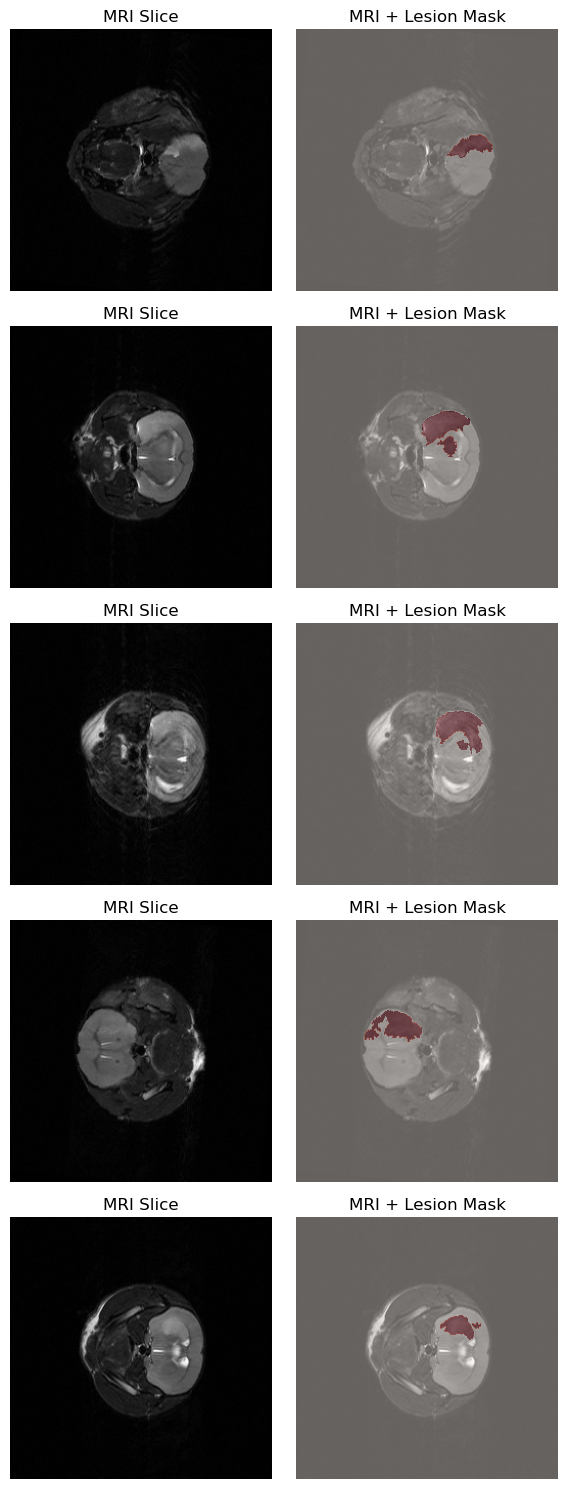

In [11]:
import matplotlib.pyplot as plt

def show_examples(dataset, num=5):
    indices = random.sample(range(len(dataset)), num)
    fig, axs = plt.subplots(num, 2, figsize=(6, 3 * num))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_np = img.squeeze().numpy()
        mask_np = mask.squeeze().numpy()

        axs[i, 0].imshow(img_np, cmap='gray')
        axs[i, 0].set_title("MRI Slice")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(img_np, cmap='gray')
        axs[i, 1].imshow(mask_np, cmap='Reds', alpha=0.4)
        axs[i, 1].set_title("MRI + Lesion Mask")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize examples from training set (e.g. intra-subject)
show_examples(inter_train)


In [11]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.up2(bottleneck)
        dec2 = self.decoder2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.up1(dec2)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))
        return torch.sigmoid(self.final(dec1))


In [6]:
def dice_coefficient(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    smooth = 1e-5
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    return ((2 * intersection + smooth) / (union + smooth)).mean().item()

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    smooth = 1e-5
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) - intersection
    return ((intersection + smooth) / (union + smooth)).mean().item()

def train_model(model, train_loader, val_loader, device, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = DiceLoss()
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': []
    }

    best_dice = 0.0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, masks = imgs.to(device), masks.to(device)
            masks = masks.float()
            if masks.max() > 1:
                masks = masks / 255.0

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.6f}")

        model.eval()
        val_loss = 0.0
        dice_total = 0.0
        iou_total = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                masks = masks.float()
                if masks.max() > 1:
                    masks = masks / 255.0
                outputs = model(imgs)
                val_loss += criterion(outputs, dice_coefficient(preds, targets, threshold=0.5))
    dice_total += dice_coefficient(outputs, masks)
    iou_total += iou_score(outputs, masks)

    avg_val_loss = val_loss / len(val_loader)
    avg_dice = dice_total / len(val_loader)
    avg_iou = iou_total / len(val_loader)

    history['val_loss'].append(avg_val_loss)
    history['val_dice'].append(avg_dice)
    history['val_iou'].append(avg_iou)

    print(f"  ✅ Validation Loss: {avg_val_loss:.6f}, Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")

    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(model.state_dict(), '/home/anastasiasinger/Downloads/model_checkpoint/best_modelcheckpoint.pth')
        print(f"✅ Saved best model (Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f})")

    # --- PLOT LOSS & METRICS ---
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['val_dice'], label='Dice Score', color='green')
    plt.title("Dice Score")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['val_iou'], label='IoU Score', color='orange')
    plt.title("IoU Score")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [23]:
train_loader = DataLoader(inter_train, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader   = DataLoader(inter_val, batch_size=8, pin_memory=True, num_workers=2)
test_loader  = DataLoader(inter_test, batch_size=8, pin_memory=True, num_workers=2)


Epoch 1/100: 100%|██████████| 295/295 [02:06<00:00,  2.33it/s]

Epoch 1 - Train Loss: 0.591573


  ✅ Validation Loss: 0.489282, Dice: 0.1805, IoU: 0.1041
✅ Saved best model (Dice: 0.1805, IoU: 0.1041)


Epoch 2/100: 100%|██████████| 295/295 [02:20<00:00,  2.10it/s]

Epoch 2 - Train Loss: 0.394136


  ✅ Validation Loss: 0.375935, Dice: 0.1738, IoU: 0.0997


Epoch 3/100: 100%|██████████| 295/295 [02:13<00:00,  2.22it/s]

Epoch 3 - Train Loss: 0.347217


  ✅ Validation Loss: 0.376459, Dice: 0.1704, IoU: 0.0976


Epoch 4/100: 100%|██████████| 295/295 [04:28<00:00,  1.10it/s]

Epoch 4 - Train Loss: 0.321491


  ✅ Validation Loss: 0.332012, Dice: 0.2629, IoU: 0.1617
✅ Saved best model (Dice: 0.2629, IoU: 0.1617)


Epoch 5/100: 100%|██████████| 295/295 [01:42<00:00,  2.87it/s]

Epoch 5 - Train Loss: 0.311413


  ✅ Validation Loss: 0.342668, Dice: 0.2809, IoU: 0.1757
✅ Saved best model (Dice: 0.2809, IoU: 0.1757)


Epoch 6/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 6 - Train Loss: 0.287893


  ✅ Validation Loss: 0.296109, Dice: 0.3311, IoU: 0.2142
✅ Saved best model (Dice: 0.3311, IoU: 0.2142)


Epoch 7/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 7 - Train Loss: 0.278618


  ✅ Validation Loss: 0.291371, Dice: 0.3275, IoU: 0.2116


Epoch 8/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 8 - Train Loss: 0.267752


  ✅ Validation Loss: 0.278539, Dice: 0.4363, IoU: 0.3055
✅ Saved best model (Dice: 0.4363, IoU: 0.3055)


Epoch 9/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 9 - Train Loss: 0.258443


  ✅ Validation Loss: 0.270862, Dice: 0.3439, IoU: 0.2241


Epoch 10/100: 100%|██████████| 295/295 [01:29<00:00,  3.28it/s]

Epoch 10 - Train Loss: 0.253809


  ✅ Validation Loss: 0.271695, Dice: 0.5224, IoU: 0.3864
✅ Saved best model (Dice: 0.5224, IoU: 0.3864)


Epoch 11/100: 100%|██████████| 295/295 [01:29<00:00,  3.28it/s]

Epoch 11 - Train Loss: 0.242709


  ✅ Validation Loss: 0.252311, Dice: 0.5060, IoU: 0.3679


Epoch 12/100: 100%|██████████| 295/295 [01:29<00:00,  3.28it/s]

Epoch 12 - Train Loss: 0.236723


  ✅ Validation Loss: 0.251595, Dice: 0.4766, IoU: 0.3415


Epoch 13/100: 100%|██████████| 295/295 [01:29<00:00,  3.28it/s]

Epoch 13 - Train Loss: 0.224416


  ✅ Validation Loss: 0.239676, Dice: 0.5475, IoU: 0.4071
✅ Saved best model (Dice: 0.5475, IoU: 0.4071)


Epoch 14/100: 100%|██████████| 295/295 [01:29<00:00,  3.28it/s]

Epoch 14 - Train Loss: 0.224716


  ✅ Validation Loss: 0.260817, Dice: 0.4900, IoU: 0.3531


Epoch 15/100: 100%|██████████| 295/295 [01:29<00:00,  3.28it/s]

Epoch 15 - Train Loss: 0.212210


  ✅ Validation Loss: 0.234157, Dice: 0.5642, IoU: 0.4228
✅ Saved best model (Dice: 0.5642, IoU: 0.4228)


Epoch 16/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 16 - Train Loss: 0.204846


  ✅ Validation Loss: 0.223235, Dice: 0.5632, IoU: 0.4225


Epoch 17/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 17 - Train Loss: 0.209808


  ✅ Validation Loss: 0.221145, Dice: 0.5663, IoU: 0.4262
✅ Saved best model (Dice: 0.5663, IoU: 0.4262)


Epoch 18/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 18 - Train Loss: 0.197551


  ✅ Validation Loss: 0.232749, Dice: 0.5260, IoU: 0.3881


Epoch 19/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 19 - Train Loss: 0.197463


  ✅ Validation Loss: 0.218519, Dice: 0.5677, IoU: 0.4276
✅ Saved best model (Dice: 0.5677, IoU: 0.4276)


Epoch 20/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 20 - Train Loss: 0.188549


  ✅ Validation Loss: 0.205152, Dice: 0.5578, IoU: 0.4161


Epoch 21/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 21 - Train Loss: 0.182993


  ✅ Validation Loss: 0.206437, Dice: 0.4856, IoU: 0.3449


Epoch 22/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 22 - Train Loss: 0.181373


  ✅ Validation Loss: 0.207364, Dice: 0.5128, IoU: 0.3746


Epoch 23/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 23 - Train Loss: 0.173793


  ✅ Validation Loss: 0.206686, Dice: 0.5484, IoU: 0.4089


Epoch 24/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 24 - Train Loss: 0.174114


  ✅ Validation Loss: 0.222083, Dice: 0.4647, IoU: 0.3268


Epoch 25/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 25 - Train Loss: 0.172399


  ✅ Validation Loss: 0.193592, Dice: 0.5327, IoU: 0.3943


Epoch 26/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 26 - Train Loss: 0.169583


  ✅ Validation Loss: 0.214698, Dice: 0.4861, IoU: 0.3456


Epoch 27/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 27 - Train Loss: 0.166311


  ✅ Validation Loss: 0.188476, Dice: 0.4554, IoU: 0.3220


Epoch 28/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 28 - Train Loss: 0.166368


  ✅ Validation Loss: 0.189832, Dice: 0.5657, IoU: 0.4250


Epoch 29/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 29 - Train Loss: 0.158298


  ✅ Validation Loss: 0.180982, Dice: 0.5426, IoU: 0.4019


Epoch 30/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 30 - Train Loss: 0.159351


  ✅ Validation Loss: 0.193891, Dice: 0.5061, IoU: 0.3687


Epoch 31/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 31 - Train Loss: 0.157958


  ✅ Validation Loss: 0.182288, Dice: 0.5790, IoU: 0.4389
✅ Saved best model (Dice: 0.5790, IoU: 0.4389)


Epoch 32/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 32 - Train Loss: 0.158923


  ✅ Validation Loss: 0.206485, Dice: 0.5190, IoU: 0.3807


Epoch 33/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 33 - Train Loss: 0.153548


  ✅ Validation Loss: 0.174837, Dice: 0.5498, IoU: 0.4081


Epoch 34/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 34 - Train Loss: 0.150001


  ✅ Validation Loss: 0.173842, Dice: 0.5568, IoU: 0.4161


Epoch 35/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 35 - Train Loss: 0.148728


  ✅ Validation Loss: 0.175684, Dice: 0.5390, IoU: 0.3985


Epoch 36/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 36 - Train Loss: 0.146852


  ✅ Validation Loss: 0.175173, Dice: 0.5551, IoU: 0.4154


Epoch 37/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 37 - Train Loss: 0.149507


  ✅ Validation Loss: 0.181378, Dice: 0.5226, IoU: 0.3828


Epoch 38/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 38 - Train Loss: 0.145067


  ✅ Validation Loss: 0.168525, Dice: 0.5557, IoU: 0.4142


Epoch 39/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 39 - Train Loss: 0.141302


  ✅ Validation Loss: 0.173382, Dice: 0.5762, IoU: 0.4350


Epoch 40/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 40 - Train Loss: 0.136269


  ✅ Validation Loss: 0.167404, Dice: 0.5047, IoU: 0.3660


Epoch 41/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]


Epoch 41 - Train Loss: 0.138029
  ✅ Validation Loss: 0.169975, Dice: 0.5403, IoU: 0.3993


Epoch 42/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 42 - Train Loss: 0.136401


  ✅ Validation Loss: 0.176861, Dice: 0.5156, IoU: 0.3776


Epoch 43/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 43 - Train Loss: 0.135651


  ✅ Validation Loss: 0.157845, Dice: 0.5447, IoU: 0.4043


Epoch 44/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 44 - Train Loss: 0.136204


  ✅ Validation Loss: 0.172706, Dice: 0.5598, IoU: 0.4197


Epoch 45/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 45 - Train Loss: 0.131293


  ✅ Validation Loss: 0.160350, Dice: 0.5602, IoU: 0.4208


Epoch 46/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 46 - Train Loss: 0.132578


  ✅ Validation Loss: 0.164857, Dice: 0.6163, IoU: 0.4784
✅ Saved best model (Dice: 0.6163, IoU: 0.4784)


Epoch 47/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 47 - Train Loss: 0.129418


  ✅ Validation Loss: 0.159089, Dice: 0.5468, IoU: 0.4062


Epoch 48/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 48 - Train Loss: 0.133201


  ✅ Validation Loss: 0.170620, Dice: 0.6767, IoU: 0.5440
✅ Saved best model (Dice: 0.6767, IoU: 0.5440)


Epoch 49/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 49 - Train Loss: 0.130099


  ✅ Validation Loss: 0.195639, Dice: 0.6875, IoU: 0.5583
✅ Saved best model (Dice: 0.6875, IoU: 0.5583)


Epoch 50/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 50 - Train Loss: 0.129303


  ✅ Validation Loss: 0.173005, Dice: 0.5124, IoU: 0.3752


Epoch 51/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 51 - Train Loss: 0.122102


  ✅ Validation Loss: 0.155913, Dice: 0.6980, IoU: 0.5723
✅ Saved best model (Dice: 0.6980, IoU: 0.5723)


Epoch 52/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 52 - Train Loss: 0.126249


  ✅ Validation Loss: 0.159774, Dice: 0.7233, IoU: 0.6006
✅ Saved best model (Dice: 0.7233, IoU: 0.6006)


Epoch 53/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 53 - Train Loss: 0.123565


  ✅ Validation Loss: 0.167816, Dice: 0.7138, IoU: 0.5905


Epoch 54/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 54 - Train Loss: 0.122409


  ✅ Validation Loss: 0.172153, Dice: 0.7771, IoU: 0.6709
✅ Saved best model (Dice: 0.7771, IoU: 0.6709)


Epoch 55/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 55 - Train Loss: 0.122468


  ✅ Validation Loss: 0.153322, Dice: 0.7151, IoU: 0.5934


Epoch 56/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]


Epoch 56 - Train Loss: 0.121830
  ✅ Validation Loss: 0.152536, Dice: 0.7361, IoU: 0.6151


Epoch 57/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 57 - Train Loss: 0.118860


  ✅ Validation Loss: 0.158419, Dice: 0.7256, IoU: 0.6060


Epoch 58/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 58 - Train Loss: 0.125622


  ✅ Validation Loss: 0.167363, Dice: 0.6085, IoU: 0.4774


Epoch 59/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 59 - Train Loss: 0.120120


  ✅ Validation Loss: 0.158659, Dice: 0.7609, IoU: 0.6470


Epoch 60/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 60 - Train Loss: 0.116507


  ✅ Validation Loss: 0.158970, Dice: 0.7591, IoU: 0.6484


Epoch 61/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 61 - Train Loss: 0.118071


  ✅ Validation Loss: 0.163001, Dice: 0.7206, IoU: 0.6012


Epoch 62/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 62 - Train Loss: 0.120565


  ✅ Validation Loss: 0.154044, Dice: 0.7619, IoU: 0.6477


Epoch 63/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 63 - Train Loss: 0.110564


  ✅ Validation Loss: 0.153602, Dice: 0.7620, IoU: 0.6521


Epoch 64/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 64 - Train Loss: 0.114162


  ✅ Validation Loss: 0.162259, Dice: 0.7278, IoU: 0.6099


Epoch 65/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 65 - Train Loss: 0.115714


  ✅ Validation Loss: 0.160089, Dice: 0.7644, IoU: 0.6526


Epoch 66/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 66 - Train Loss: 0.109953


  ✅ Validation Loss: 0.151542, Dice: 0.7888, IoU: 0.6831
✅ Saved best model (Dice: 0.7888, IoU: 0.6831)


Epoch 67/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 67 - Train Loss: 0.110692


  ✅ Validation Loss: 0.147638, Dice: 0.7705, IoU: 0.6609


Epoch 68/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 68 - Train Loss: 0.110970


  ✅ Validation Loss: 0.149567, Dice: 0.7370, IoU: 0.6208


Epoch 69/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 69 - Train Loss: 0.108693


  ✅ Validation Loss: 0.151205, Dice: 0.7846, IoU: 0.6767


Epoch 70/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 70 - Train Loss: 0.107856


  ✅ Validation Loss: 0.155847, Dice: 0.8010, IoU: 0.6981
✅ Saved best model (Dice: 0.8010, IoU: 0.6981)


Epoch 71/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 71 - Train Loss: 0.113331


  ✅ Validation Loss: 0.161958, Dice: 0.7147, IoU: 0.5960


Epoch 72/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 72 - Train Loss: 0.108250


  ✅ Validation Loss: 0.152198, Dice: 0.7772, IoU: 0.6708


Epoch 73/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 73 - Train Loss: 0.107248


  ✅ Validation Loss: 0.151184, Dice: 0.8127, IoU: 0.7144
✅ Saved best model (Dice: 0.8127, IoU: 0.7144)


Epoch 74/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]


Epoch 74 - Train Loss: 0.104627
  ✅ Validation Loss: 0.152565, Dice: 0.7989, IoU: 0.6945


Epoch 75/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 75 - Train Loss: 0.104727


  ✅ Validation Loss: 0.158266, Dice: 0.8020, IoU: 0.7015


Epoch 76/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 76 - Train Loss: 0.107099


  ✅ Validation Loss: 0.149398, Dice: 0.7960, IoU: 0.6948


Epoch 77/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 77 - Train Loss: 0.104670


  ✅ Validation Loss: 0.149238, Dice: 0.7771, IoU: 0.6692


Epoch 78/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 78 - Train Loss: 0.101197


  ✅ Validation Loss: 0.148146, Dice: 0.8199, IoU: 0.7237
✅ Saved best model (Dice: 0.8199, IoU: 0.7237)


Epoch 79/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 79 - Train Loss: 0.119048


  ✅ Validation Loss: 0.147271, Dice: 0.7986, IoU: 0.6976


Epoch 80/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 80 - Train Loss: 0.101202


  ✅ Validation Loss: 0.149148, Dice: 0.7902, IoU: 0.6858


Epoch 81/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 81 - Train Loss: 0.100857


  ✅ Validation Loss: 0.144995, Dice: 0.8061, IoU: 0.7060


Epoch 82/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 82 - Train Loss: 0.104923


  ✅ Validation Loss: 0.155669, Dice: 0.7794, IoU: 0.6716


Epoch 83/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 83 - Train Loss: 0.106239


  ✅ Validation Loss: 0.145441, Dice: 0.8143, IoU: 0.7202


Epoch 84/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 84 - Train Loss: 0.095979


  ✅ Validation Loss: 0.146050, Dice: 0.8087, IoU: 0.7080


Epoch 85/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 85 - Train Loss: 0.097566


  ✅ Validation Loss: 0.150426, Dice: 0.7792, IoU: 0.6743


Epoch 86/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 86 - Train Loss: 0.100366


  ✅ Validation Loss: 0.144517, Dice: 0.8196, IoU: 0.7232


Epoch 87/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 87 - Train Loss: 0.095707


  ✅ Validation Loss: 0.150424, Dice: 0.8179, IoU: 0.7211


Epoch 88/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 88 - Train Loss: 0.096376


  ✅ Validation Loss: 0.155140, Dice: 0.7829, IoU: 0.6762


Epoch 89/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 89 - Train Loss: 0.101240


  ✅ Validation Loss: 0.148012, Dice: 0.8120, IoU: 0.7147


Epoch 90/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 90 - Train Loss: 0.100086


  ✅ Validation Loss: 0.148303, Dice: 0.8120, IoU: 0.7136


Epoch 91/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 91 - Train Loss: 0.093965


  ✅ Validation Loss: 0.152023, Dice: 0.7913, IoU: 0.6854


Epoch 92/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 92 - Train Loss: 0.096087


  ✅ Validation Loss: 0.145372, Dice: 0.8203, IoU: 0.7234
✅ Saved best model (Dice: 0.8203, IoU: 0.7234)


Epoch 93/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 93 - Train Loss: 0.092086


  ✅ Validation Loss: 0.155426, Dice: 0.8398, IoU: 0.7497
✅ Saved best model (Dice: 0.8398, IoU: 0.7497)


Epoch 94/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 94 - Train Loss: 0.094692


  ✅ Validation Loss: 0.155815, Dice: 0.7948, IoU: 0.6915


Epoch 95/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 95 - Train Loss: 0.090959


  ✅ Validation Loss: 0.141087, Dice: 0.8224, IoU: 0.7269


Epoch 96/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 96 - Train Loss: 0.091386


  ✅ Validation Loss: 0.144967, Dice: 0.8270, IoU: 0.7324


Epoch 97/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 97 - Train Loss: 0.090142


  ✅ Validation Loss: 0.148889, Dice: 0.8181, IoU: 0.7225


Epoch 98/100: 100%|██████████| 295/295 [01:29<00:00,  3.29it/s]

Epoch 98 - Train Loss: 0.096422


  ✅ Validation Loss: 0.155906, Dice: 0.8391, IoU: 0.7504


Epoch 99/100: 100%|██████████| 295/295 [01:29<00:00,  3.30it/s]

Epoch 99 - Train Loss: 0.093575


  ✅ Validation Loss: 0.141390, Dice: 0.8309, IoU: 0.7380


Epoch 100/100: 100%|██████████| 295/295 [01:29<00:00,  3.30it/s]

Epoch 100 - Train Loss: 0.088757


  ✅ Validation Loss: 0.149951, Dice: 0.8376, IoU: 0.7479


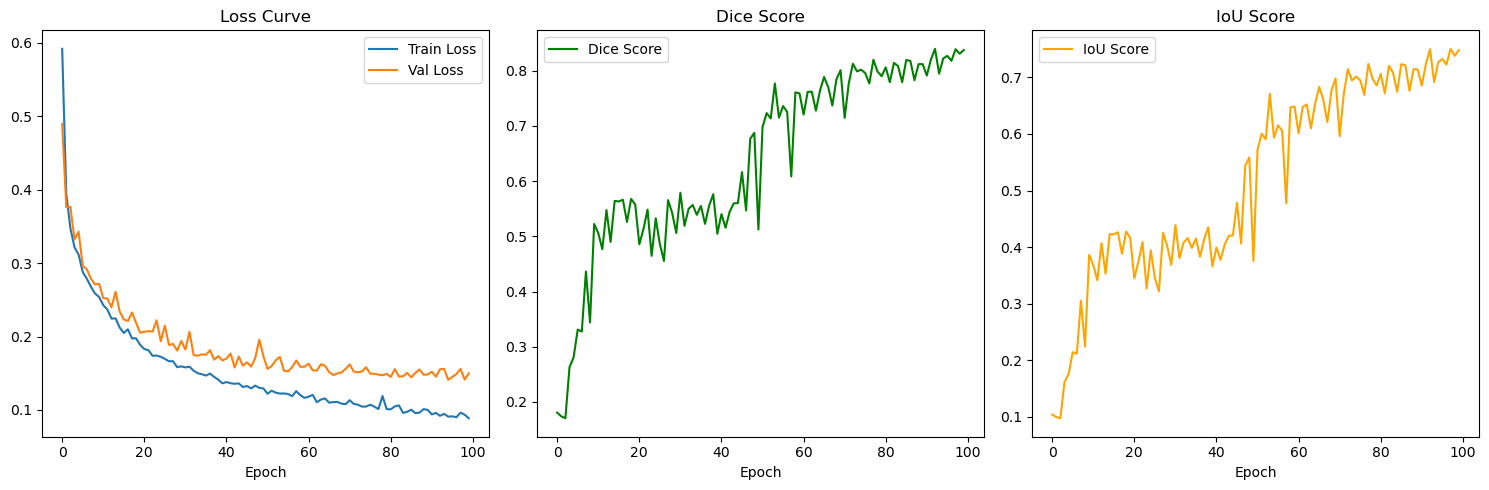

In [27]:
from monai.losses import DiceLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True  

model = UNet().to(device)
torch.cuda.empty_cache()
train_model(model, train_loader, val_loader, device, epochs=100) 


In [13]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
       
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_intra = UNet()
model_intra.load_state_dict(torch.load("/home/anastasiasinger/Documents/checkpoint/best_model_diceloss.pth", map_location=DEVICE))  
model_intra.to(DEVICE)  
model_intra.eval()
model_inter = UNet()
model_inter.load_state_dict(torch.load("/home/anastasiasinger/Downloads/model_checkpoint/checkpoint.pth", map_location=DEVICE))  
model_inter.to(DEVICE)  
model_inter.eval()

UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (up2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (decoder2): Sequential(
    (0): C

In [15]:

def evaluate_model(model, loader, device):
    model.eval()
    dices, ious = [], []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            dices.append(dice_coefficient(outputs, masks))
            ious.append(iou_score(outputs, masks))
    return np.mean(dices), np.mean(ious)
    
intra_test_loader = DataLoader(intra_test, batch_size=8, pin_memory=True, num_workers=2)
inter_test_loader = DataLoader(inter_test, batch_size=8, pin_memory=True, num_workers=2)
dice_inter, iou_inter = evaluate_model(model_inter, inter_test_loader, DEVICE)
dice_intra, iou_intra = evaluate_model(model_intra, intra_test_loader, DEVICE)


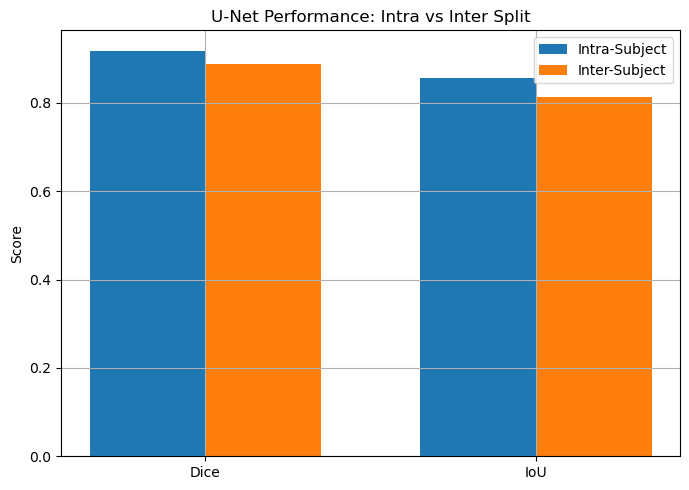

In [16]:
import matplotlib.pyplot as plt

labels = ['Dice', 'IoU']
intra_scores = [dice_intra, iou_intra]
inter_scores = [dice_inter, iou_inter]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(x - width/2, intra_scores, width, label='Intra-Subject')
ax.bar(x + width/2, inter_scores, width, label='Inter-Subject')

ax.set_ylabel('Score')
ax.set_title('U-Net Performance: Intra vs Inter Split')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
dices_inter, ious_inter = evaluate_model(model_inter, inter_test_loader, DEVICE)

print('Inter-subject splitting scores: ')
print(f'✅ Test Dice: {dices_inter:.4f} | IoU: {ious_inter:.4f}')

Inter-subject splitting scores: 
✅ Test Dice: 0.8881 | IoU: 0.8129
